# LA Wildfire Prediction: Data and Model Visualization


In [19]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import joblib

# For displaying plots in the notebook
%matplotlib inline


## Data Loading
The following function loads the engineered wildfire dataset for visualization.


In [21]:
def load_data(file_path):
   
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    
    # Print the head of loaded data
    print("\nLoaded Data Head:")
    print(df.head())
    
    return df


## Data Distribution Visualization
Visualize the distribution of data across months and years to identify temporal patterns.


In [23]:
def visualize_data_distribution(df):
   
    print("Visualizing data distribution...")
    
    # Create directory if it doesn't exist
    os.makedirs('../reports/figures', exist_ok=True)
    
    # Monthly distribution of data
    if 'date' in df.columns:
        df['month'] = df['date'].dt.month
        monthly_counts = df.groupby('month').size().reset_index(name='count')
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='month', y='count', data=monthly_counts)
        plt.title('Monthly Distribution of Data')
        plt.xlabel('Month')
        plt.ylabel('Count')
        plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.savefig('../reports/figures/monthly_data_distribution.png')
        plt.show()
    
    # Yearly distribution of data
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        yearly_counts = df.groupby('year').size().reset_index(name='count')
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='year', y='count', data=yearly_counts)
        plt.title('Yearly Distribution of Data')
        plt.xlabel('Year')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.savefig('../reports/figures/yearly_data_distribution.png')
        plt.show()


## Weather Pattern Visualization
Visualize the distribution and seasonal patterns of key weather variables like temperature, precipitation, and wind speed.


In [25]:
def visualize_weather_patterns(df):
    
    print("Visualizing weather patterns...")
    
    # Create directory if it doesn't exist
    os.makedirs('../reports/figures', exist_ok=True)
    
    # Temperature distribution
    if 'TMAX' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df['TMAX'], kde=True)
        plt.title('Distribution of Maximum Temperature')
        plt.xlabel('Maximum Temperature (°F)')
        plt.ylabel('Count')
        plt.savefig('../reports/figures/temperature_distribution.png')
        plt.show()
    
    # Precipitation distribution
    if 'PRCP' in df.columns:
        plt.figure(figsize=(12, 6))
        # Filter out zero precipitation for better visualization
        prcp_nonzero = df[df['PRCP'] > 0]['PRCP']
        sns.histplot(prcp_nonzero, kde=True)
        plt.title('Distribution of Non-Zero Precipitation')
        plt.xlabel('Precipitation (inches)')
        plt.ylabel('Count')
        plt.savefig('../reports/figures/precipitation_distribution.png')
        plt.show()
    
    # Wind speed distribution
    if 'AWND' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df['AWND'], kde=True)
        plt.title('Distribution of Wind Speed')
        plt.xlabel('Wind Speed (mph)')
        plt.ylabel('Count')
        plt.savefig('../reports/figures/wind_distribution.png')
        plt.show()
    
    # Temperature by month
    if 'TMAX' in df.columns and 'date' in df.columns:
        df['month'] = df['date'].dt.month
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='month', y='TMAX', data=df)
        plt.title('Maximum Temperature by Month')
        plt.xlabel('Month')
        plt.ylabel('Maximum Temperature (°F)')
        plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.savefig('../reports/figures/temperature_by_month.png')
        plt.show()
    
    # Precipitation by month
    if 'PRCP' in df.columns and 'date' in df.columns:
        df['month'] = df['date'].dt.month
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='month', y='PRCP', data=df)
        plt.title('Precipitation by Month')
        plt.xlabel('Month')
        plt.ylabel('Precipitation (inches)')
        plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.savefig('../reports/figures/precipitation_by_month.png')
        plt.show()


## Feature Correlation Visualization
Visualize correlations between features to identify relationships and potential multicollinearity.


In [27]:
def visualize_feature_correlations(df):
   
    print("Visualizing feature correlations...")
    
    # Create directory if it doesn't exist
    os.makedirs('../reports/figures', exist_ok=True)
    
    # Select numeric columns for correlation
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Limit to a reasonable number of features for readability
    if len(numeric_cols) > 15:
        # Prioritize important features
        important_features = [
            'TMAX', 'TMIN', 'PRCP', 'AWND',
            'dry_streak', 'is_dry', 'LST_Day_C'
        ]
        # Add additional features if they exist
        additional_features = [
            col for col in numeric_cols 
            if col not in important_features and 
            any(suffix in col for suffix in ['_7D', '_3D', '_prev', 'drought', 'fire_spread'])
        ]
        # Combine and limit
        selected_cols = important_features + additional_features
        selected_cols = [col for col in selected_cols if col in numeric_cols]
        if len(selected_cols) > 15:
            selected_cols = selected_cols[:15]
    else:
        selected_cols = numeric_cols
    
    # Calculate correlation matrix
    corr_matrix = df[selected_cols].corr()
    
    # Visualize correlation matrix
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('../reports/figures/feature_correlation.png')
    plt.show()


## Dryness Feature Visualization
Visualize dryness-related features which are critical for wildfire prediction.


In [29]:
def visualize_dryness_features(df):
  
    print("Visualizing dryness features...")
    
    # Create directory if it doesn't exist
    os.makedirs('../reports/figures', exist_ok=True)
    
    # Days since rain distribution
    if 'days_since_rain' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df['days_since_rain'], kde=True)
        plt.title('Distribution of Days Since Rain')
        plt.xlabel('Days Since Rain')
        plt.ylabel('Count')
        plt.savefig('../reports/figures/days_since_rain_distribution.png')
        plt.show()
    
    # Drought index distribution
    if 'drought_index' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df['drought_index'], kde=True)
        plt.title('Distribution of Drought Index')
        plt.xlabel('Drought Index')
        plt.ylabel('Count')
        plt.savefig('../reports/figures/drought_index_distribution.png')
        plt.show()
    
    # Fire spread potential distribution
    if 'fire_spread_potential' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df['fire_spread_potential'], kde=True)
        plt.title('Distribution of Fire Spread Potential')
        plt.xlabel('Fire Spread Potential')
        plt.ylabel('Count')
        plt.savefig('../reports/figures/fire_spread_potential_distribution.png')
        plt.show()
    
    # Days since rain by month
    if 'days_since_rain' in df.columns and 'date' in df.columns:
        df['month'] = df['date'].dt.month
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='month', y='days_since_rain', data=df)
        plt.title('Days Since Rain by Month')
        plt.xlabel('Month')
        plt.ylabel('Days Since Rain')
        plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.savefig('../reports/figures/days_since_rain_by_month.png')
        plt.show()


## Model Prediction Visualization
Visualize the model's predictions, including distribution of predicted values, actual vs predicted comparison, and prediction errors.


In [31]:
def visualize_model_predictions(model_path, data_path, feature_path):
  
    print("Visualizing model predictions...")
    
    # Create directory if it doesn't exist
    os.makedirs('../reports/figures', exist_ok=True)
    
    # Load model, data, and feature names
    model = joblib.load(model_path)
    df = pd.read_csv(data_path)
    with open(feature_path, 'r') as f:
        feature_names = [line.strip() for line in f]
    
    # Ensure all required features are present
    missing_features = [f for f in feature_names if f not in df.columns]
    if missing_features:
        print(f"Warning: Missing features in data: {missing_features}")
        for feature in missing_features:
            df[feature] = 0  # Add missing features with default values
    
    # Create target variable for evaluation
    if 'fire_spread_potential' in df.columns:
        y_actual = df['fire_spread_potential']
        # Keep all features including fire_spread_potential for prediction
        X = df[feature_names]
        print("Using fire_spread_potential as target variable for prediction visualization")
    else:
        # Create a synthetic target based on temperature and dryness
        if 'TMAX' in df.columns and 'days_since_rain' in df.columns:
            y_actual = (df['TMAX'] / 100) * (df['days_since_rain'] / 30)
            X = df[feature_names]
            print("Created synthetic target based on temperature and dryness for prediction visualization")
        else:
            # Create random target for demonstration
            y_actual = np.random.rand(len(df))
            X = df[feature_names]
            print("Created random target for prediction visualization")
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Add predictions to dataframe
    df['predicted_value'] = y_pred
    df['actual_value'] = y_actual
    
    # Visualize prediction distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(df['predicted_value'], kde=True, bins=50)  # Fixed number of bins
    plt.title('Distribution of Predicted Values')
    plt.xlabel('Predicted Value')
    plt.ylabel('Count')
    plt.savefig('../reports/figures/prediction_distribution.png')
    plt.show()
    
    # Visualize actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_pred, alpha=0.5)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted Values')
    plt.savefig('../reports/figures/actual_vs_predicted.png')
    plt.show()
    
    # Visualize predictions by month
    if 'date' in df.columns:
        df['month'] = pd.to_datetime(df['date']).dt.month
        monthly_avg_pred = df.groupby('month')['predicted_value'].mean().reset_index()
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='month', y='predicted_value', data=monthly_avg_pred)
        plt.title('Average Predicted Value by Month')
        plt.xlabel('Month')
        plt.ylabel('Average Predicted Value')
        plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.savefig('../reports/figures/monthly_prediction.png')
        plt.show()
    
    # Visualize prediction error - using plt.hist instead of sns.histplot to avoid memory issues
    df['prediction_error'] = df['actual_value'] - df['predicted_value']
    plt.figure(figsize=(12, 6))
    try:
        # Try with sns.histplot first with fixed bins
        sns.histplot(df['prediction_error'], kde=True, bins=50)
    except (np.core._exceptions._ArrayMemoryError, MemoryError):
        print("Memory error encountered with seaborn histplot, using matplotlib histogram instead")
        # Fall back to matplotlib hist which is more memory efficient
        plt.hist(df['prediction_error'], bins=50, alpha=0.7)
        plt.axvline(x=0, color='r', linestyle='--')
    
    plt.title('Distribution of Prediction Error')
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.savefig('../reports/figures/prediction_error_distribution.png')
    plt.show()


## Main Execution
Run the complete visualization pipeline.


In [33]:
def main():
    """Main function for creating visualizations."""
    # Define file paths
    data_path = "../data/processed/engineered_la_fire_data.csv"
    model_path = "../models/la_fire_random_forest_model.pkl"
    feature_path = "../models/feature_names.txt"
    
    # Load data
    df = load_data(data_path)
    
    # Create visualizations
    visualize_data_distribution(df)
    visualize_weather_patterns(df)
    visualize_feature_correlations(df)
    visualize_dryness_features(df)
    
    # Check if model exists
    if os.path.exists(model_path) and os.path.exists(feature_path):
        visualize_model_predictions(model_path, data_path, feature_path)
    
    print("Visualizations created successfully!")


Loading data from ../data/processed/engineered_la_fire_data.csv...

Loaded Data Head:
        date  Fire_Occurred STATION NAME  AWND  DAPR  MDPR  PGTM  PRCP  TAVG  \
0 2014-12-27              0       0    0   0.0   0.0   0.0   0.0   0.0   0.0   
1 2014-12-28              0       0    0   0.0   0.0   0.0   0.0   0.0   0.0   
2 2014-12-29              0       0    0   0.0   0.0   0.0   0.0   0.0   0.0   
3 2014-12-30              0       0    0   0.0   0.0   0.0   0.0   0.0   0.0   
4 2014-12-31              0       0    0   0.0   0.0   0.0   0.0   0.0   0.0   

   ...  season_Summer  season_Fall  TMAX_3D  TMIN_3D  PRCP_3D  PRCP_14D  \
0  ...          False         True      0.0      0.0      0.0       0.0   
1  ...          False         True      0.0      0.0      0.0       0.0   
2  ...          False         True      0.0      0.0      0.0       0.0   
3  ...          False         True      0.0      0.0      0.0       0.0   
4  ...          False         True      0.0      0.0      

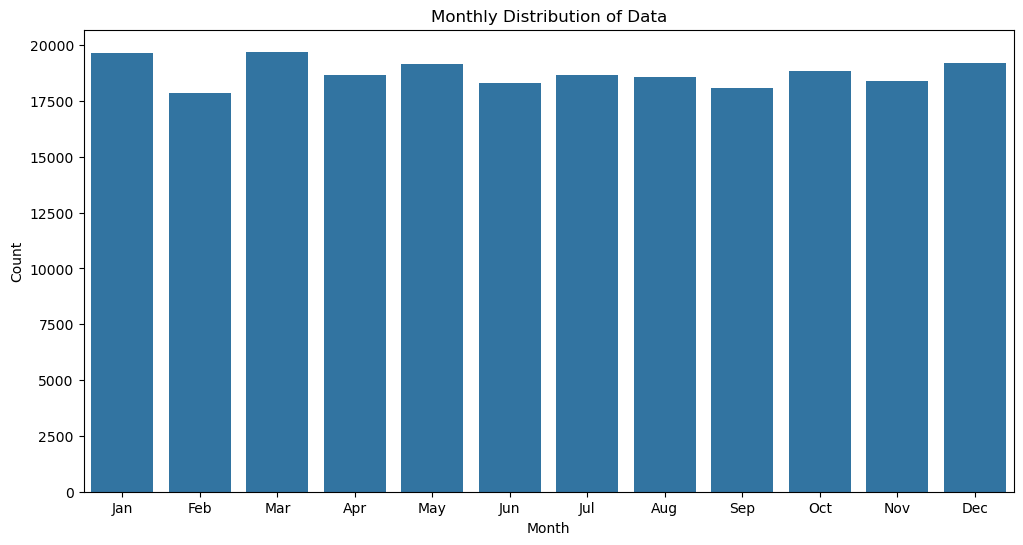

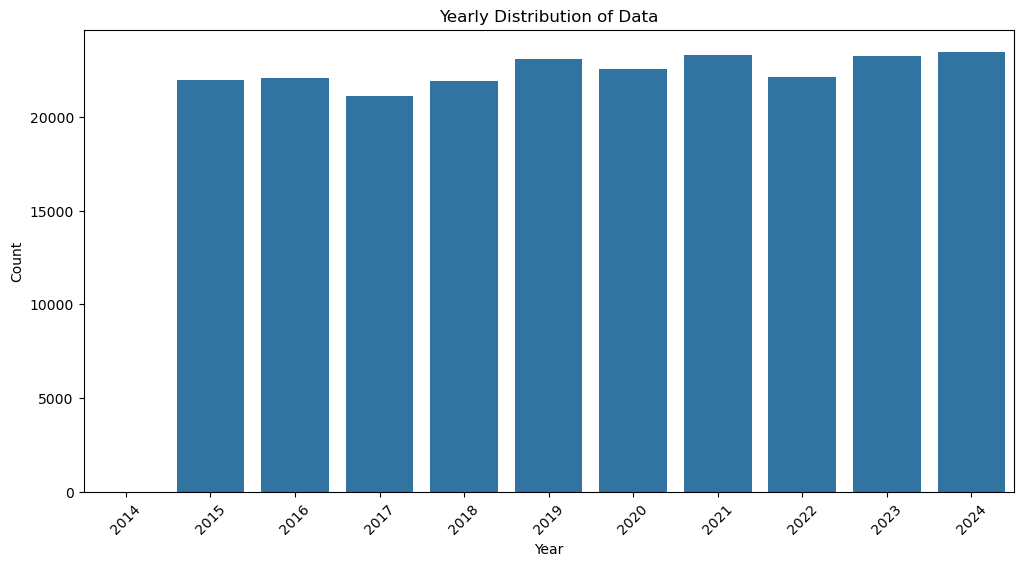

Visualizing weather patterns...


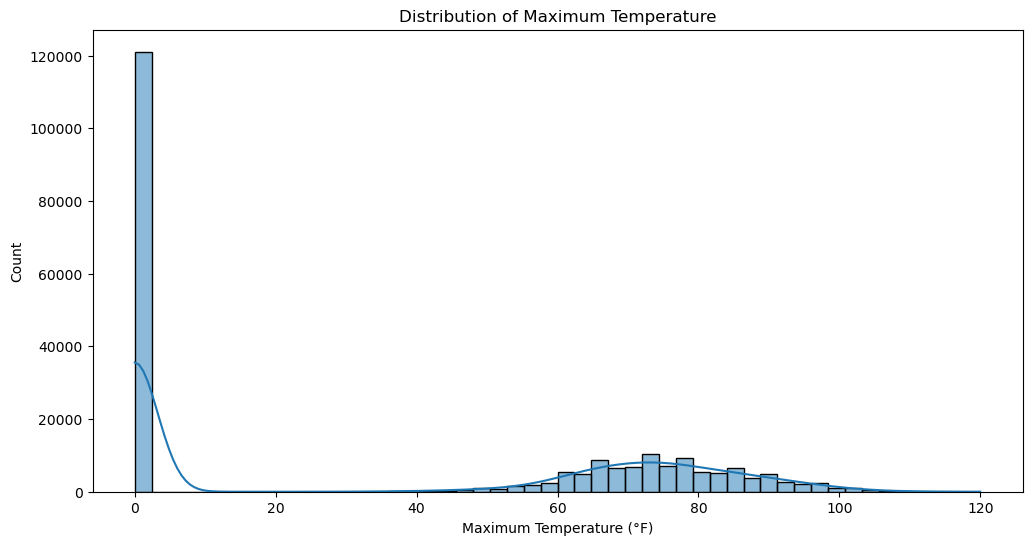

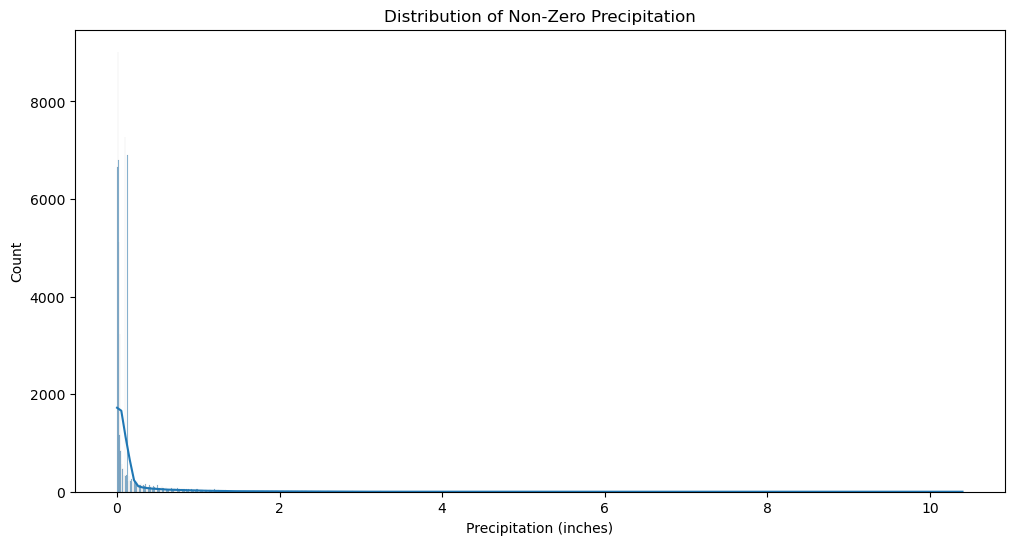

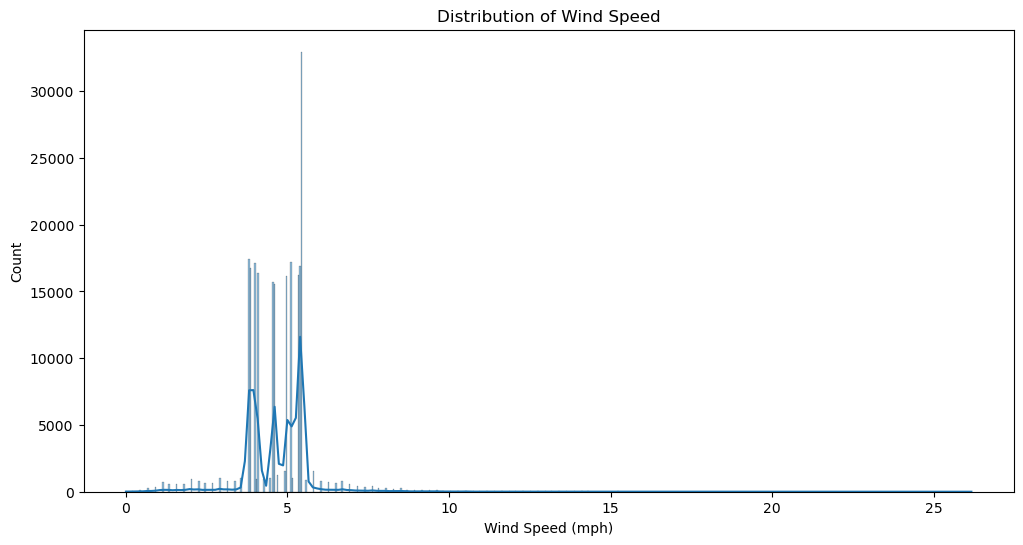

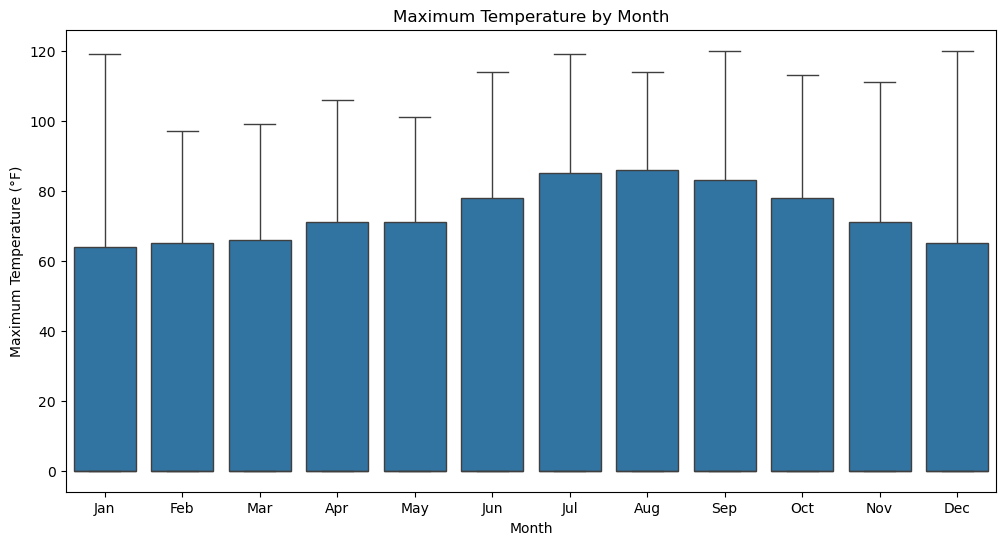

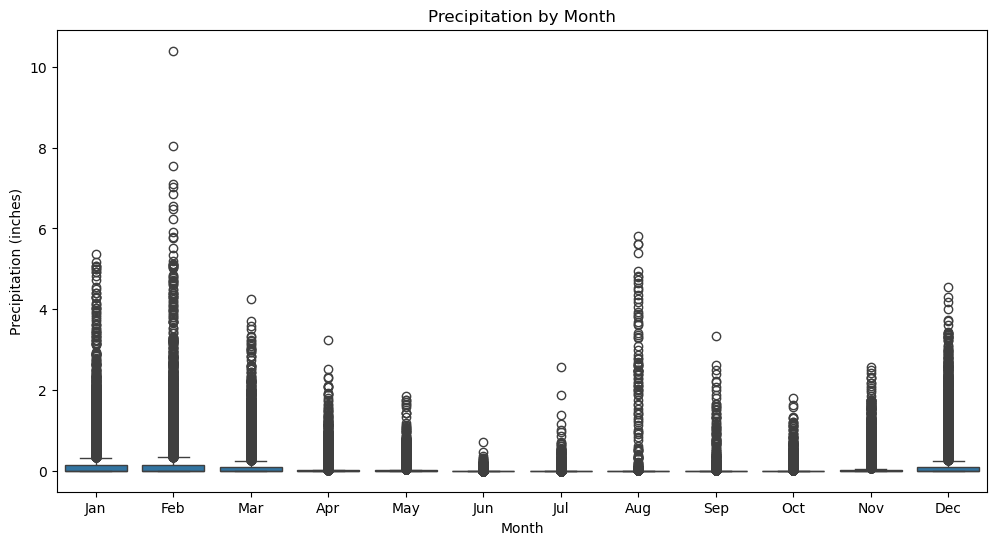

Visualizing feature correlations...


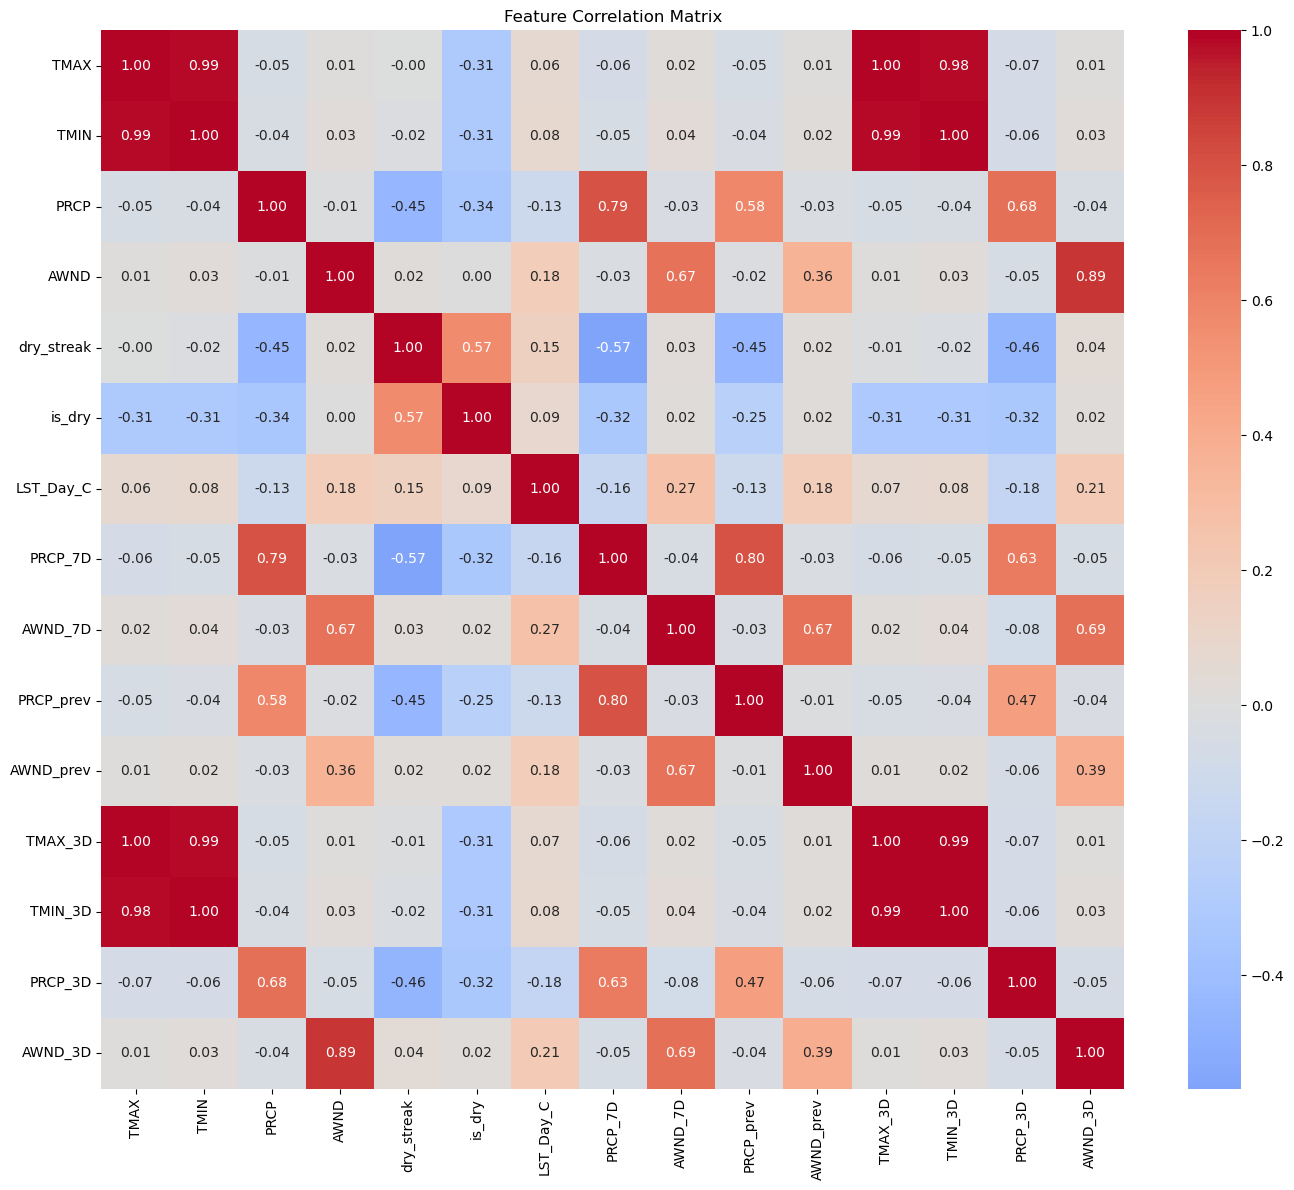

Visualizing dryness features...


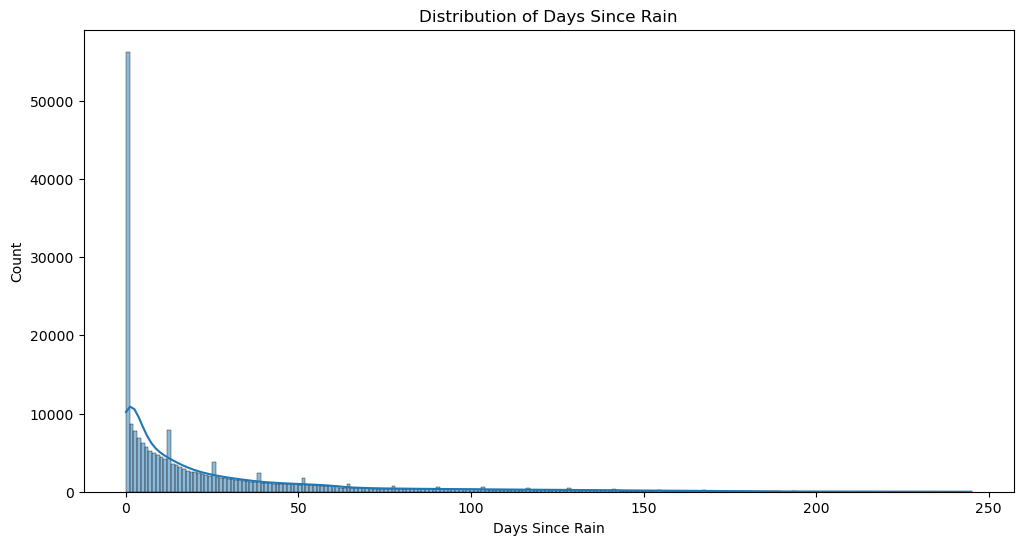

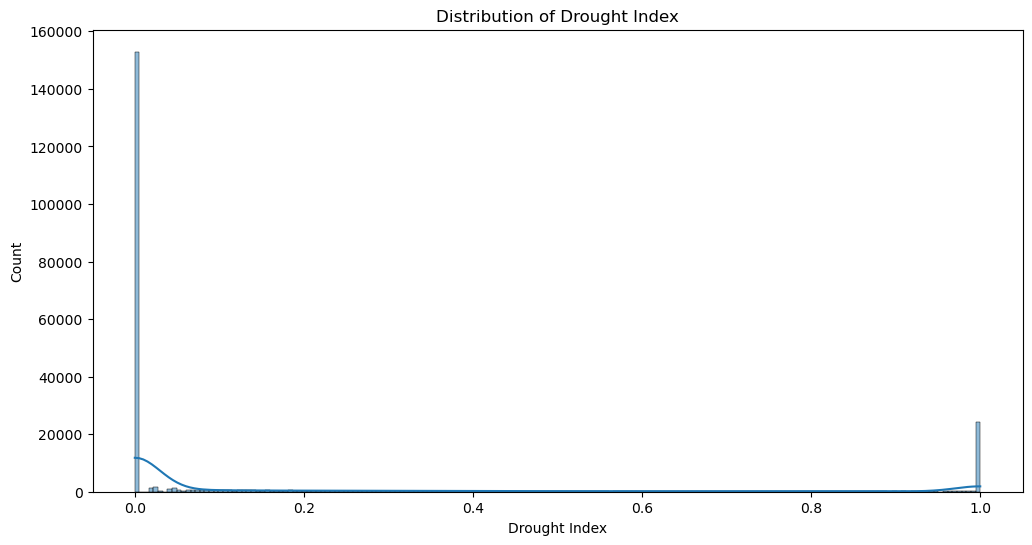

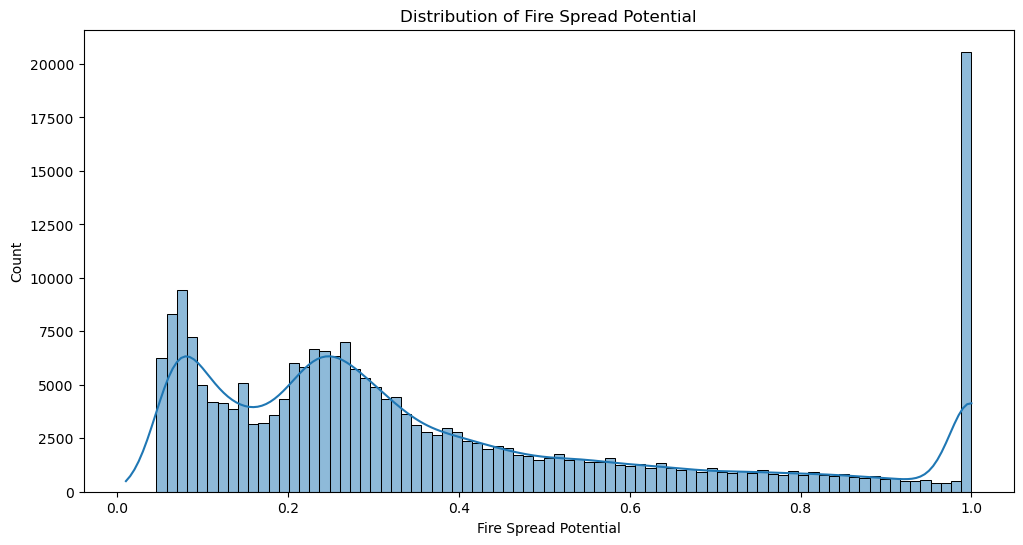

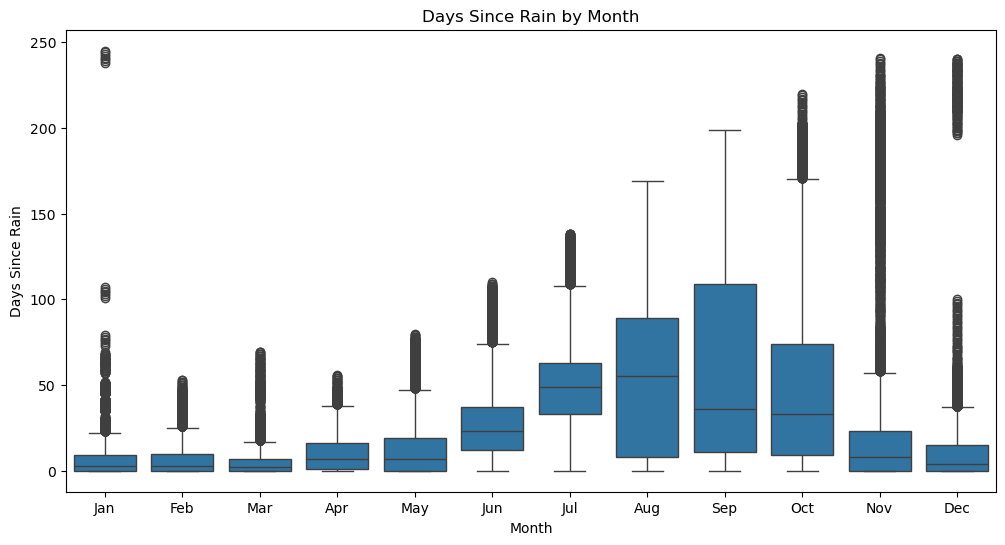

Visualizing model predictions...
Using fire_spread_potential as target variable for prediction visualization


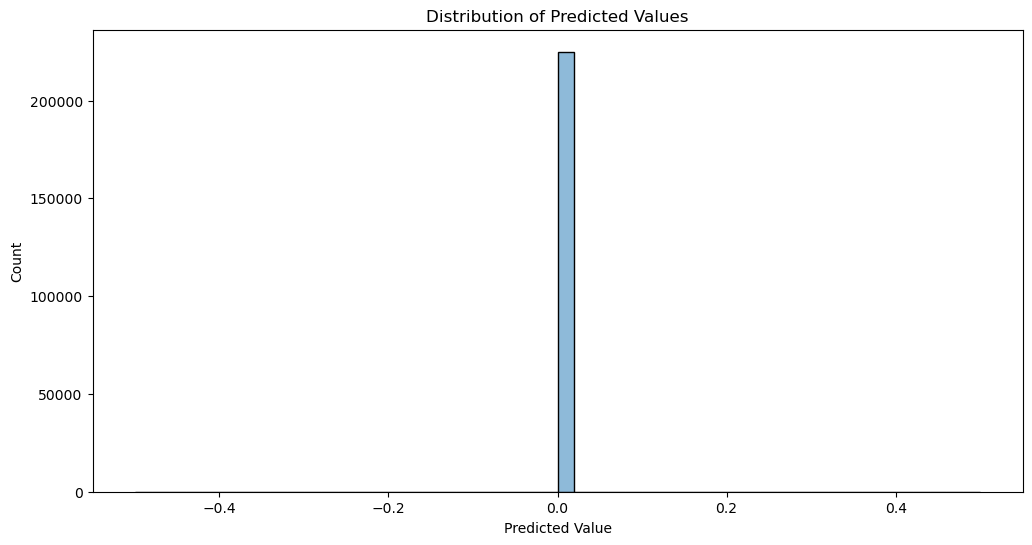

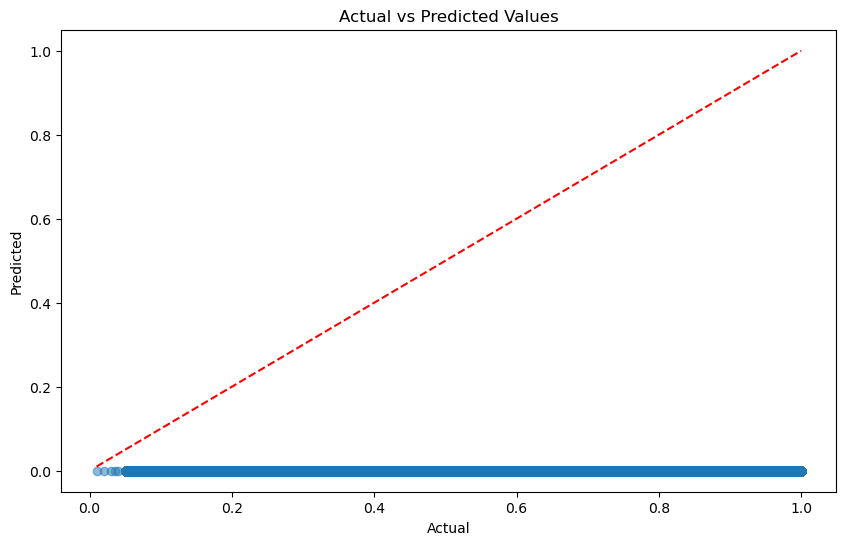

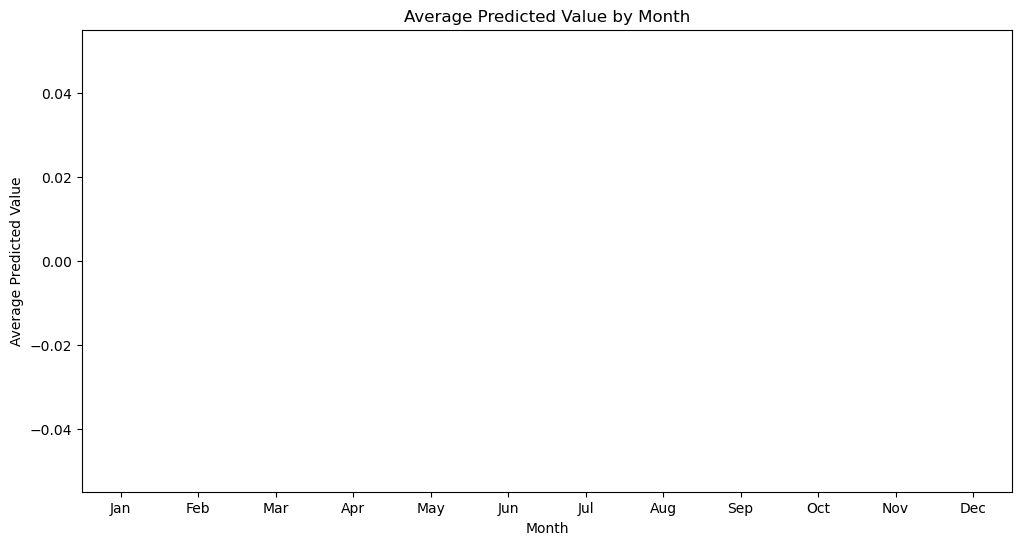

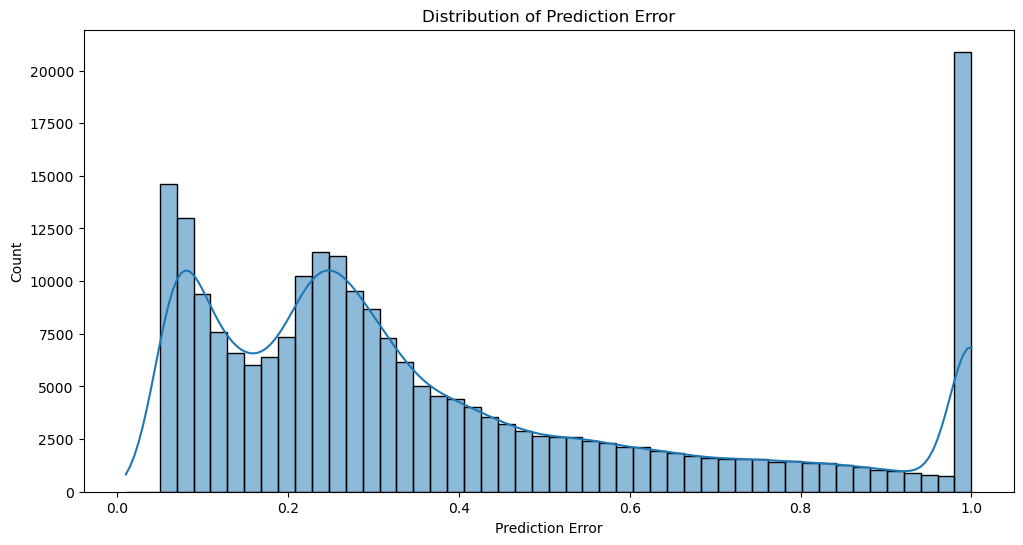

Visualizations created successfully!


In [17]:
# Execute the visualization pipeline
main()
